In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
df = pd.read_excel("Aufgabe_1_Gloss_Optimization.xlsx")
df

,V13,V15,V16,V18,V19,V21,V28,V29,V30,V31,V32,V33,V34,V39,gloss
0,0.10,HMW 1,0.05,LMW 1,0.05,LMW 6,-0.004681,0.103880,0.000972,-0.005881,0.055534,0.058750,-0.004681,8,6200
1,0.12,HMW 1,0.04,LMW 1,0.04,LMW 6,-0.010345,0.112653,0.001479,0.005503,0.040954,0.056777,-0.010345,8,6400
2,0.12,HMW 1,0.06,LMW 1,0.02,LMW 6,-0.005359,0.125634,0.003815,-0.012599,0.074109,0.015341,-0.005359,8,5800
3,0.14,HMW 1,0.04,LMW 1,0.02,LMW 6,-0.004240,0.147946,-0.016650,0.010005,0.039433,0.018663,-0.004240,6,6200
4,0.28,HMW 1,0.08,LMW 1,0.04,LMW 6,-0.026882,0.284841,-0.009568,-0.019216,0.068883,0.038201,-0.026882,8,8600
5,0.12,HMW 1,0.06,LMW 1,0.02,LMW 7,-0.012378,0.131851,-0.009754,0.003244,0.059373,0.026450,-0.012378,8,4800
6,0.24,HMW 1,0.12,LMW 1,0.04,LMW 7,-0.003660,0.244951,0.016939,-0.012309,0.123884,0.042937,-0.003660,8,6800
7,0.14,HMW 1,0.04,LMW 1,0.02,LMW 7,0.006664,0.125695,-0.004785,-0.004625,0.037321,0.018528,0.006664,6,4000
8,0.28,HMW 1,0.08,LMW 1,0.04,LMW 7,0.018571,0.288215,-0.007519,0.003315,0.079077,0.046381,0.018571,8,6600
9,0.10,HMW 1,0.05,LMW 1,0.05,LMW 3,0.007331,0.103919,0.002864,-0.014808,0.067368,0.005788,0.007331,8,7300


In [3]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V13     58 non-null     float64
 1   V15     58 non-null     object 
 2   V16     58 non-null     float64
 3   V18     49 non-null     object 
 4   V19     58 non-null     float64
 5   V21     15 non-null     object 
 6   V28     58 non-null     float64
 7   V29     58 non-null     float64
 8   V30     58 non-null     float64
 9   V31     58 non-null     float64
 10  V32     58 non-null     float64
 11  V33     58 non-null     float64
 12  V34     58 non-null     float64
 13  V39     58 non-null     int64  
 14  gloss   58 non-null     int64  
dtypes: float64(10), int64(2), object(3)
memory usage: 6.9+ KB


V13       0
V15       0
V16       0
V18       9
V19       0
V21      43
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V39       0
gloss     0
dtype: int64

In [4]:
# Drop V21 because of too many missing values
df = df.drop(columns=["V21"])

# Handle missing values in V18
# Option 1: Replace NaN with "Missing"
df["V18"] = df["V18"].fillna("Missing")

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=["V15", "V18"], drop_first=True)

# Split features/target
X = df_encoded.drop("gloss", axis=1)
y = df_encoded["gloss"]

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

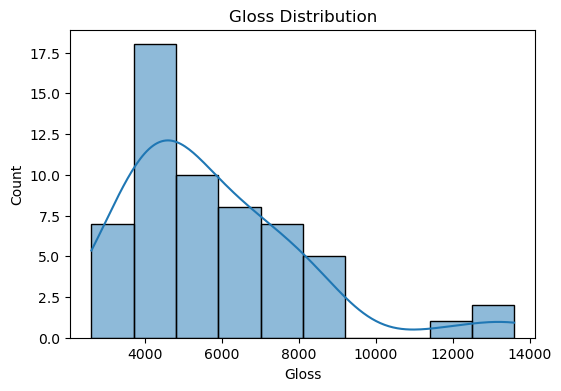

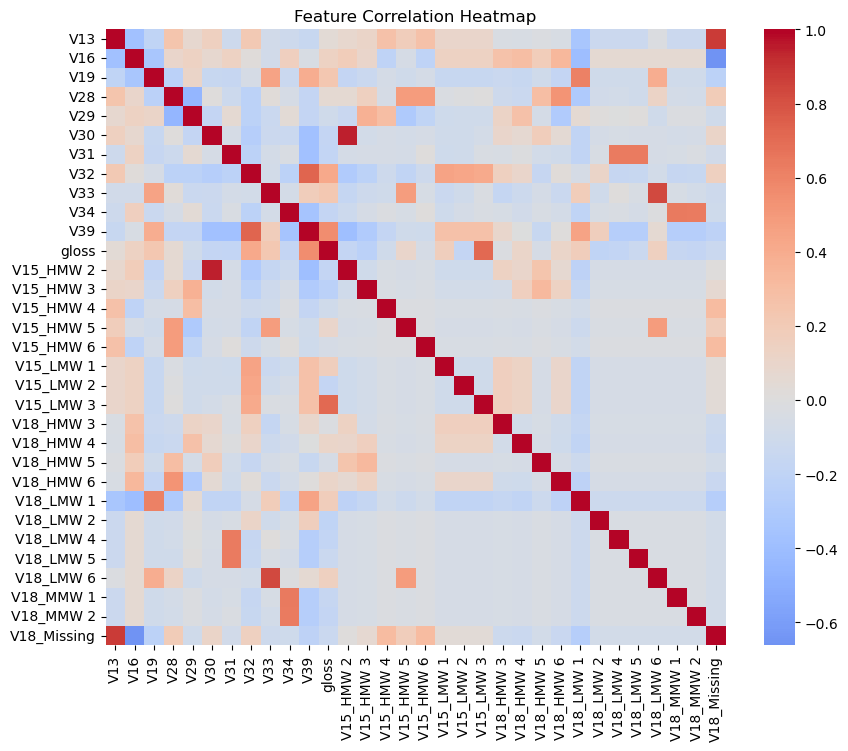

Correlation of features with gloss:
 gloss          1.000000
V15_LMW 3      0.712937
V39            0.554567
V32            0.419360
V19            0.228708
V33            0.221077
V18_LMW 1      0.170556
V15_LMW 1      0.163239
V18_LMW 6      0.154392
V16            0.138185
V18_HMW 4      0.108270
V18_HMW 6      0.106229
V15_HMW 5      0.102049
V28            0.063715
V13            0.040160
V18_HMW 3     -0.024095
V18_HMW 5     -0.054981
V15_HMW 6     -0.058289
V15_HMW 4     -0.092154
V29           -0.102683
V18_LMW 5     -0.135510
V18_Missing   -0.135846
V18_MMW 1     -0.155642
V30           -0.168900
V15_HMW 2     -0.171198
V34           -0.172249
V18_MMW 2     -0.175774
V15_LMW 2     -0.177050
V18_LMW 4     -0.183827
V31           -0.185285
V18_LMW 2     -0.199932
V15_HMW 3     -0.232848
Name: gloss, dtype: float64


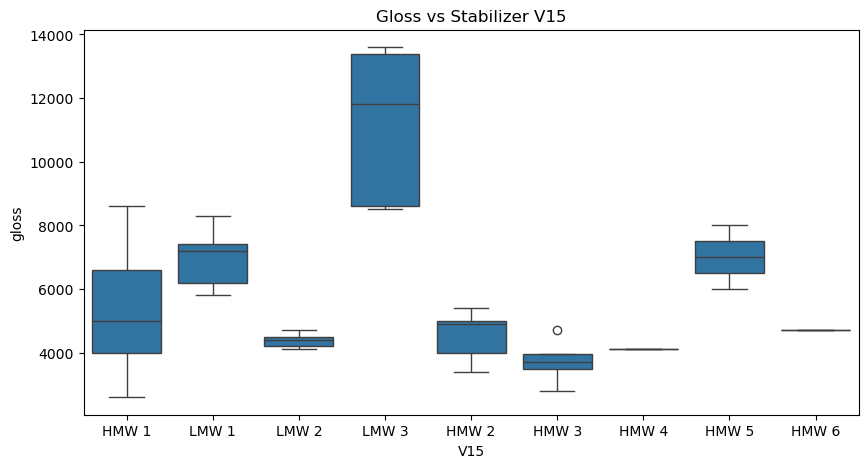

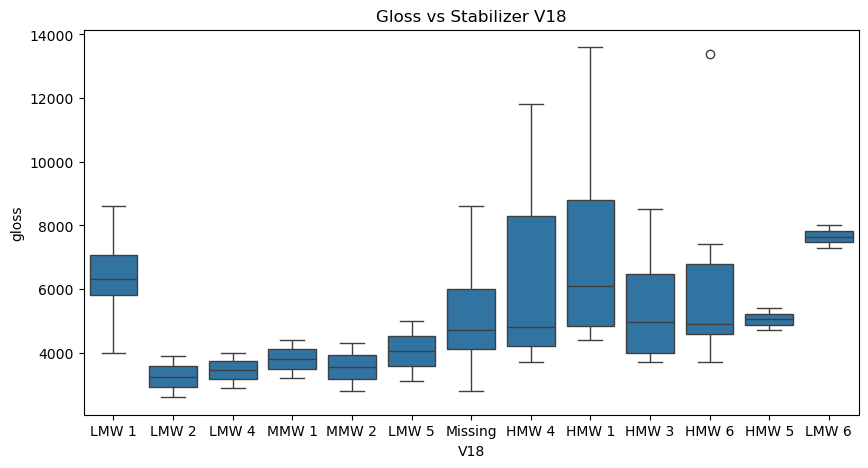

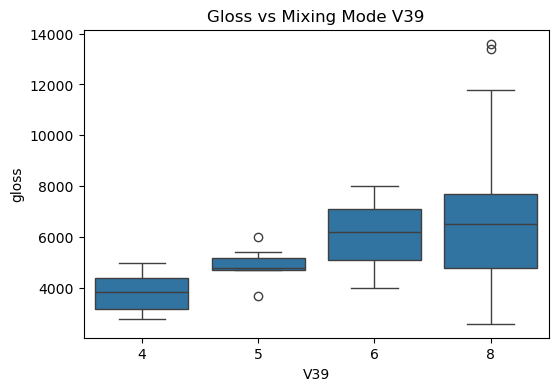

In [5]:
# 1. Distribution of target variable (gloss)
plt.figure(figsize=(6,4))
sns.histplot(y, kde=True, bins=10)
plt.title("Gloss Distribution")
plt.xlabel("Gloss")
plt.ylabel("Count")
plt.show()

# 2. Correlation heatmap (numerical features only)
plt.figure(figsize=(10,8))
corr = df_encoded.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# 3. Correlation of each feature with gloss
corr_target = corr["gloss"].sort_values(ascending=False)
print("Correlation of features with gloss:\n", corr_target)

# 4. Boxplots for categorical variables (before encoding)
plt.figure(figsize=(10,5))
sns.boxplot(x="V15", y="gloss", data=df)
plt.title("Gloss vs Stabilizer V15")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x="V18", y="gloss", data=df)
plt.title("Gloss vs Stabilizer V18")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x="V39", y="gloss", data=df)
plt.title("Gloss vs Mixing Mode V39")
plt.show()

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Baseline Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Linear Regression R²:", r2)
print("Linear Regression RMSE:", rmse)

# Cross-validation (k=5)
cv_scores = cross_val_score(lr, X_scaled, y, cv=5, scoring="r2")
print("CV R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

Linear Regression R²: 0.3814113137888576
Linear Regression RMSE: 1659.1839813083411
CV R² scores: [ -4.28253089  -3.63406107 -11.64066448  -0.6378826   -0.93147395]
Mean CV R²: -4.225322599674878


In [8]:
SEED = 42

DATA_PATH = "Aufgabe_1_Gloss_Optimization.xlsx"  
TARGET = None  # Set to 'Gloss' or leave None to auto-detect common names

# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

import joblib

In [9]:
def _load_data(path):
    if path.lower().endswith('.csv'):
        return pd.read_csv(path)
    elif path.lower().endswith(('.xls', '.xlsx')):
        return pd.read_excel(path)
    else:
        raise ValueError("Supported formats: .csv, .xls, .xlsx")

df = _load_data(DATA_PATH)
print("Dataset shape:", df.shape)
display(df.head(8))
display(df.info())
display(df.describe(include='all').T)

# Auto-detect target if not provided
if TARGET is None:
    candidates = [c for c in df.columns if c.lower() in ('gloss', 'glanz', 'target')]
    if len(candidates) >= 1:
        TARGET = candidates[0]
        print(f"TARGET auto-set to: {TARGET!r}")
    else:
        raise ValueError("Please set TARGET variable name (e.g. 'Gloss').")

Dataset shape: (58, 15)


,V13,V15,V16,V18,V19,V21,V28,V29,V30,V31,V32,V33,V34,V39,gloss
0,0.10,HMW 1,0.05,LMW 1,0.05,LMW 6,-0.004681,0.103880,0.000972,-0.005881,0.055534,0.058750,-0.004681,8,6200
1,0.12,HMW 1,0.04,LMW 1,0.04,LMW 6,-0.010345,0.112653,0.001479,0.005503,0.040954,0.056777,-0.010345,8,6400
2,0.12,HMW 1,0.06,LMW 1,0.02,LMW 6,-0.005359,0.125634,0.003815,-0.012599,0.074109,0.015341,-0.005359,8,5800
3,0.14,HMW 1,0.04,LMW 1,0.02,LMW 6,-0.004240,0.147946,-0.016650,0.010005,0.039433,0.018663,-0.004240,6,6200
4,0.28,HMW 1,0.08,LMW 1,0.04,LMW 6,-0.026882,0.284841,-0.009568,-0.019216,0.068883,0.038201,-0.026882,8,8600
5,0.12,HMW 1,0.06,LMW 1,0.02,LMW 7,-0.012378,0.131851,-0.009754,0.003244,0.059373,0.026450,-0.012378,8,4800
6,0.24,HMW 1,0.12,LMW 1,0.04,LMW 7,-0.003660,0.244951,0.016939,-0.012309,0.123884,0.042937,-0.003660,8,6800
7,0.14,HMW 1,0.04,LMW 1,0.02,LMW 7,0.006664,0.125695,-0.004785,-0.004625,0.037321,0.018528,0.006664,6,4000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V13     58 non-null     float64
 1   V15     58 non-null     object 
 2   V16     58 non-null     float64
 3   V18     49 non-null     object 
 4   V19     58 non-null     float64
 5   V21     15 non-null     object 
 6   V28     58 non-null     float64
 7   V29     58 non-null     float64
 8   V30     58 non-null     float64
 9   V31     58 non-null     float64
 10  V32     58 non-null     float64
 11  V33     58 non-null     float64
 12  V34     58 non-null     float64
 13  V39     58 non-null     int64  
 14  gloss   58 non-null     int64  
dtypes: float64(10), int64(2), object(3)
memory usage: 6.9+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
V13,58.0,NaN,NaN,NaN,0.212069,0.093203,0.1,0.14,0.2,0.2,0.4
V15,58,9,HMW 1,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V16,58.0,NaN,NaN,NaN,0.123103,0.080398,0.0,0.05,0.11,0.2,0.2
V18,49,12,LMW 1,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V19,58.0,NaN,NaN,NaN,0.009655,0.019463,0.0,0.0,0.0,0.015,0.1
V21,15,4,LMW 6,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V28,58.0,NaN,NaN,NaN,0.045749,0.100995,-0.026882,-0.004095,0.00292,0.013207,0.414315
V29,58.0,NaN,NaN,NaN,0.155069,0.108409,-0.022175,0.102278,0.187456,0.205533,0.407974
V30,58.0,NaN,NaN,NaN,0.021873,0.076145,-0.025433,-0.00741,0.000285,0.005757,0.395204
V31,58.0,NaN,NaN,NaN,0.010464,0.041409,-0.019216,-0.006435,0.001588,0.008385,0.20607


TARGET auto-set to: 'gloss'


In [10]:
n_rows = df.shape[0]
missing = df.isna().sum().to_frame(name='n_missing')
missing['pct_missing'] = (missing['n_missing'] / n_rows * 100).round(2)
missing = missing.sort_values('n_missing', ascending=False)
display(missing.head(30))

,n_missing,pct_missing
V21,43,74.14
V18,9,15.52
V13,0,0.00
V15,0,0.00
V16,0,0.00
V19,0,0.00
V28,0,0.00
V29,0,0.00
V30,0,0.00
V31,0,0.00


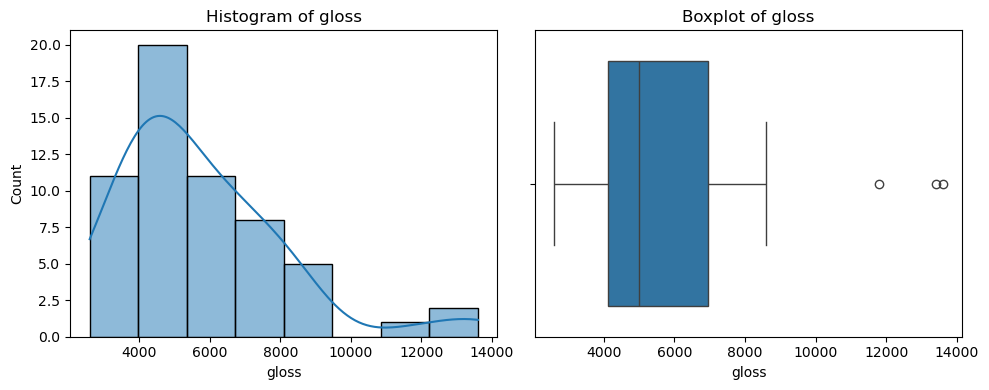

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df[TARGET].dropna(), kde=True)
plt.title(f'Histogram of {TARGET}')

plt.subplot(1,2,2)
sns.boxplot(x=df[TARGET])
plt.title(f'Boxplot of {TARGET}')
plt.tight_layout()
plt.show()

In [12]:
X = df.drop(columns=[TARGET]).copy()
y = df[TARGET].copy()

cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X.select_dtypes(include=[np.number]).columns.tolist()

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

Numeric features: ['V13', 'V16', 'V19', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V39']
Categorical features: ['V15', 'V18', 'V21']


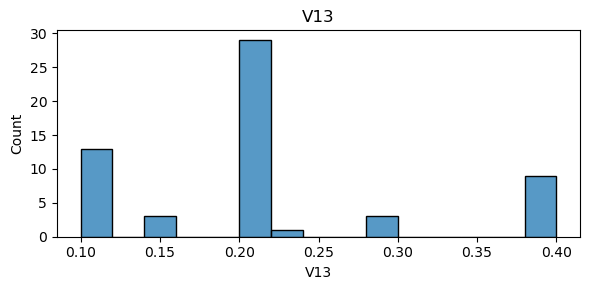

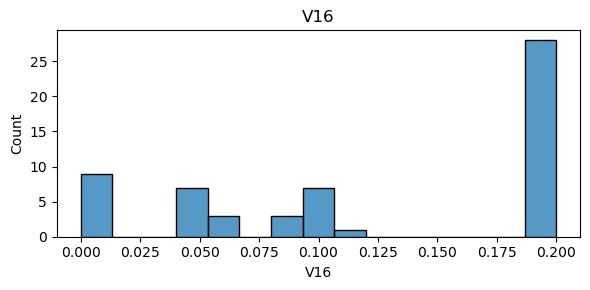

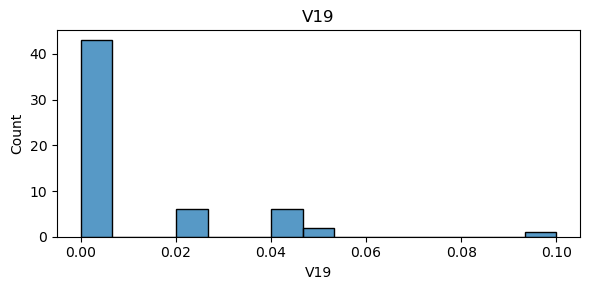

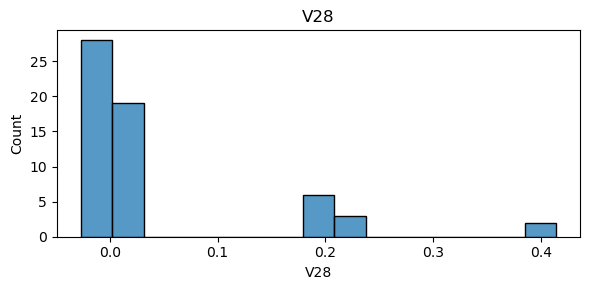

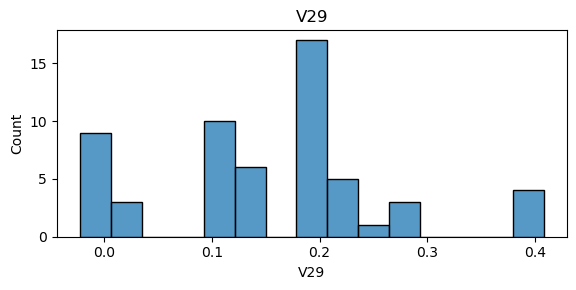

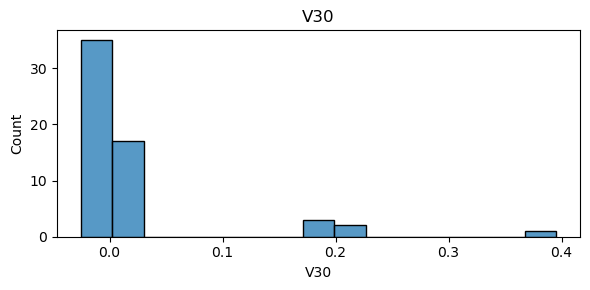

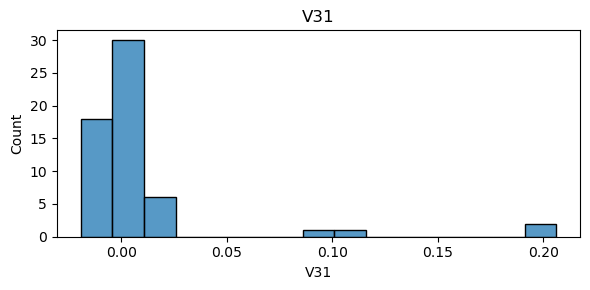

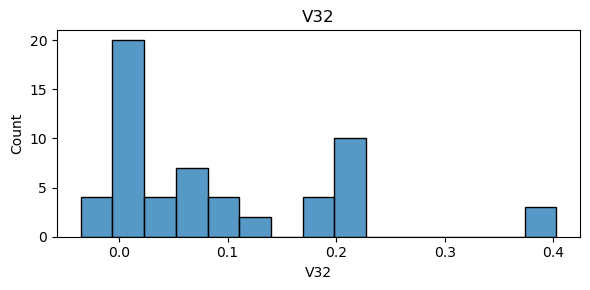

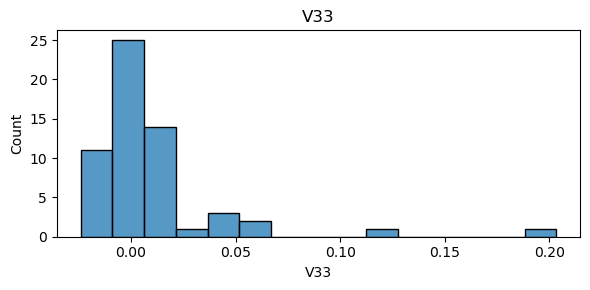

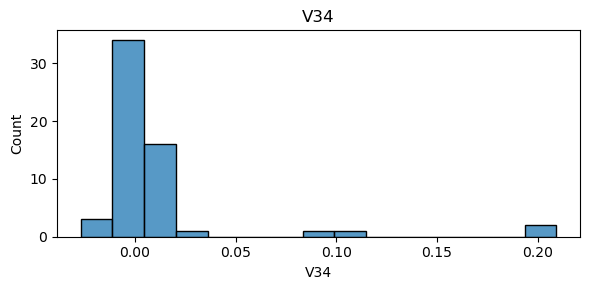

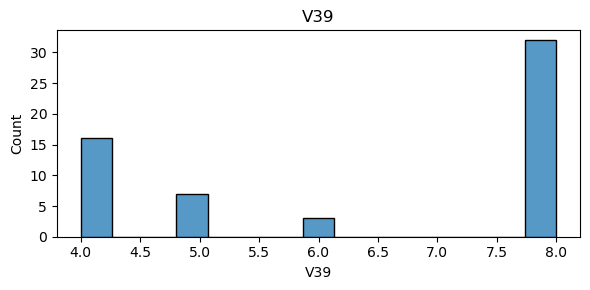


Value counts for V15:


V15
HMW 1    29
HMW 2     6
LMW 1     5
LMW 2     5
LMW 3     5
HMW 3     4
HMW 5     2
HMW 4     1
HMW 6     1
Name: count, dtype: int64

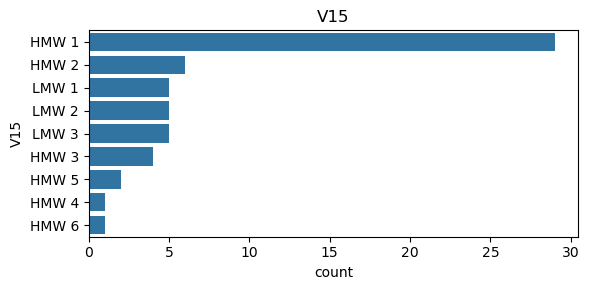


Value counts for V18:


V18
LMW 1    16
NaN       9
HMW 6     6
HMW 4     5
HMW 1     4
HMW 3     4
LMW 2     2
LMW 4     2
MMW 1     2
MMW 2     2
LMW 5     2
HMW 5     2
LMW 6     2
Name: count, dtype: int64

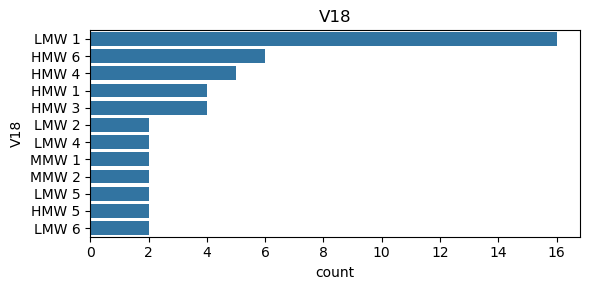


Value counts for V21:


V21
NaN      43
LMW 6     5
LMW 3     5
LMW 7     4
LMW 1     1
Name: count, dtype: int64

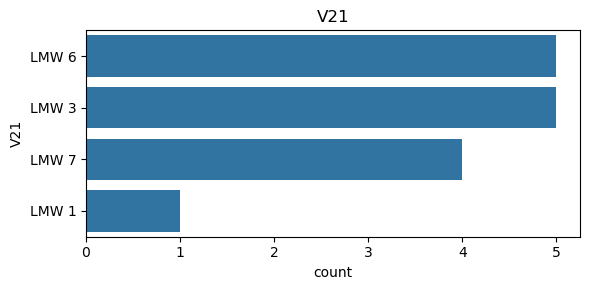

In [13]:
for col in num_features:
    plt.figure(figsize=(6,3))
    sns.histplot(X[col].dropna(), bins=15, kde=False)
    plt.title(col)
    plt.tight_layout()
    plt.show()

# Categorical value counts
for col in cat_features:
    print(f"\nValue counts for {col}:")
    display(X[col].value_counts(dropna=False))
    plt.figure(figsize=(6,3))
    sns.countplot(y=X[col], order=X[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()
    plt.show()

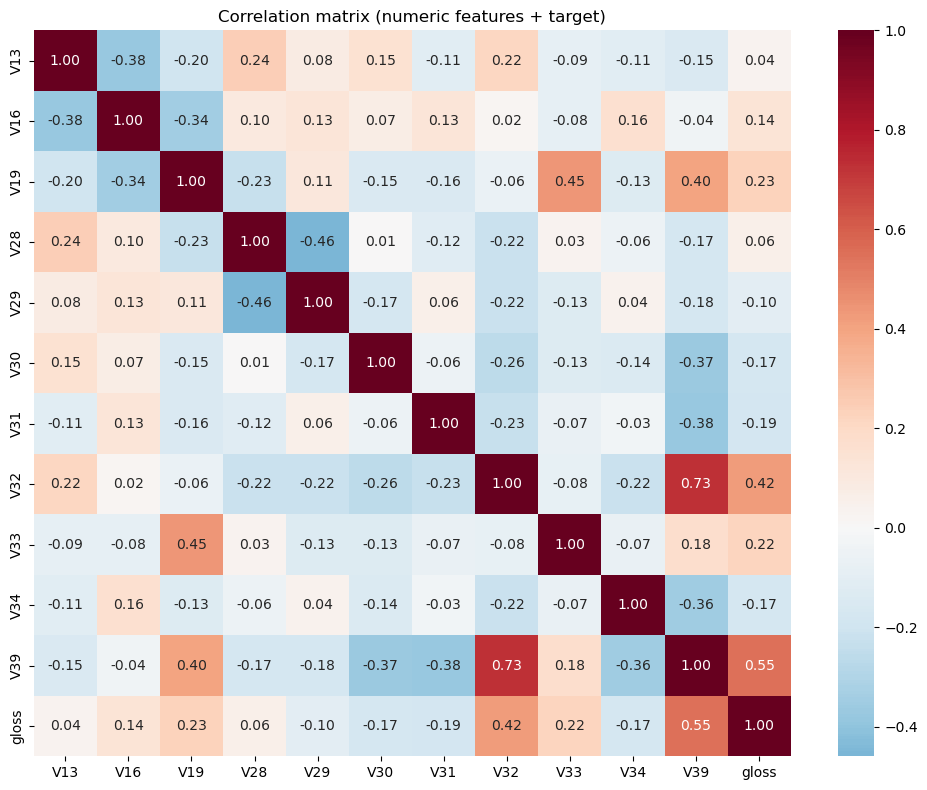

Absolute correlation with target (descending):


V39    0.554567
V32    0.419360
V19    0.228708
V33    0.221077
V31    0.185285
V34    0.172249
V30    0.168900
V16    0.138185
V29    0.102683
V28    0.063715
V13    0.040160
Name: gloss, dtype: float64

In [14]:
if len(num_features) > 0:
    corr = df[num_features + [TARGET]].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
    plt.title("Correlation matrix (numeric features + target)")
    plt.tight_layout()
    plt.show()

    # Correlation with target
    corr_to_target = corr[TARGET].drop(labels=[TARGET]).abs().sort_values(ascending=False)
    print("Absolute correlation with target (descending):")
    display(corr_to_target)
else:
    print("No numeric features to compute correlations.")

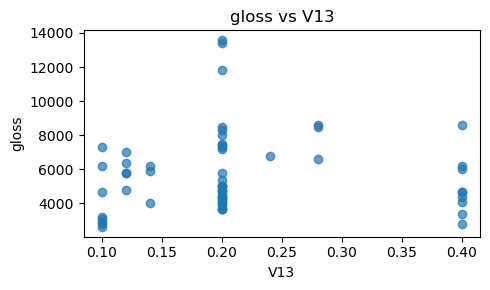

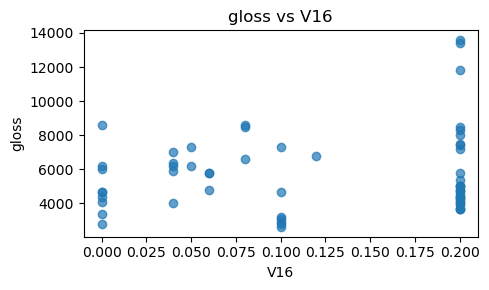

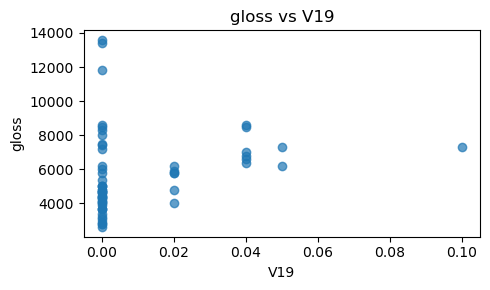

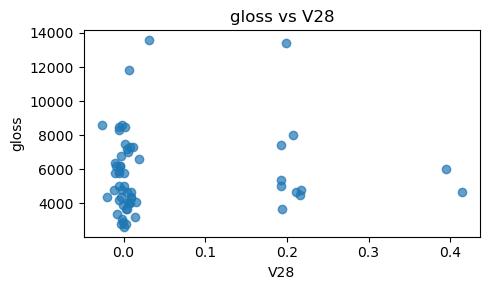

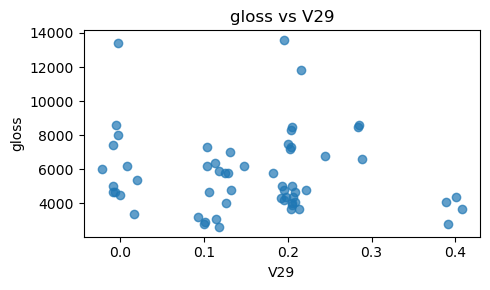

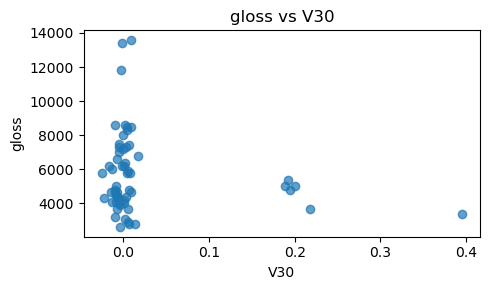

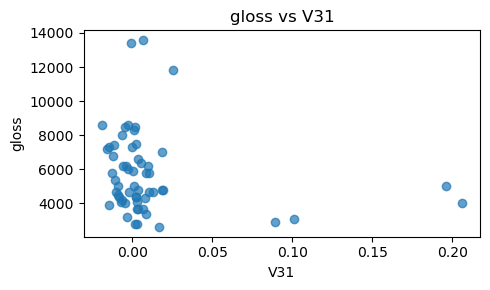

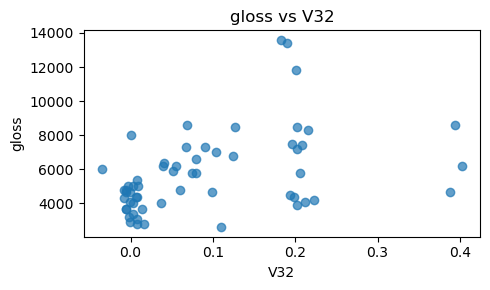

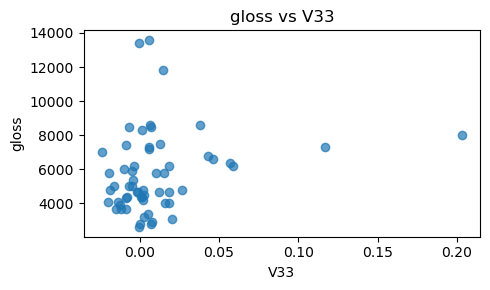

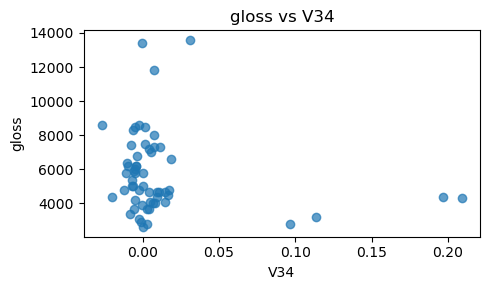

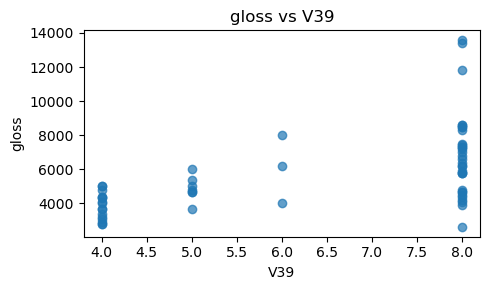

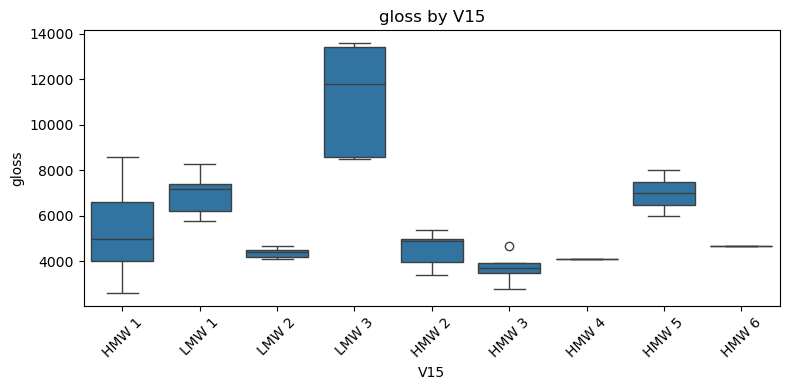

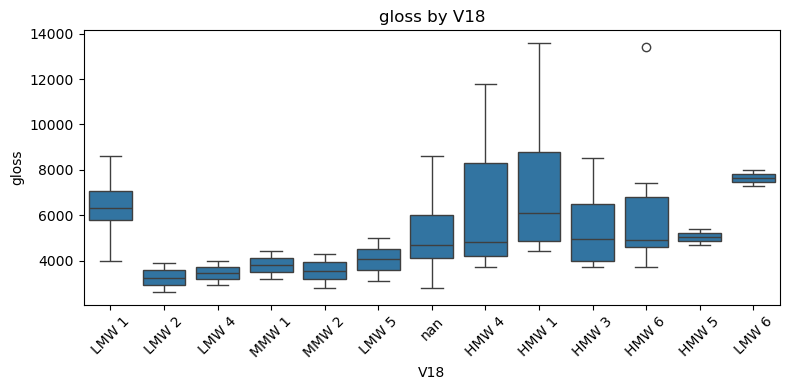

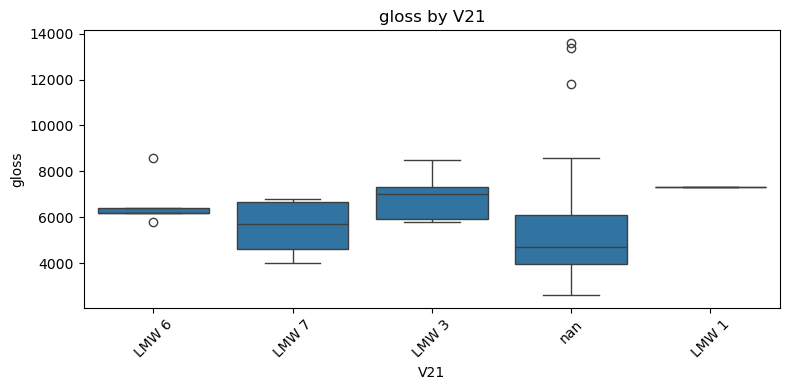

In [15]:
for col in num_features:
    plt.figure(figsize=(5,3))
    plt.scatter(X[col], y, alpha=0.7)
    plt.xlabel(col); plt.ylabel(TARGET)
    plt.title(f"{TARGET} vs {col}")
    plt.tight_layout()
    plt.show()

# Boxplots: target vs categorical
for col in cat_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=X[col].astype(str), y=y)
    plt.xticks(rotation=45)
    plt.title(f"{TARGET} by {col}")
    plt.tight_layout()
    plt.show()

In [11]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Additional useful libraries
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.linear_model import Lasso, HuberRegressor
from sklearn.svm import SVR

import statsmodels.api as sm
from itertools import cycle
from multiprocessing import cpu_count
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

In [13]:
data = pd.read_excel("Aufgabe_1_Gloss_Optimization.xlsx")

# Make sure that full rows are printed without being cut off
pd.set_option("display.expand_frame_repr", False)

# Show dataset dimensions and a preview of the last rows
print(f'Dataset "Gloss_Optimization" dimensions: {data.shape[0]} rows, {data.shape[1]} columns\n')
data.tail()

Dataset "Gloss_Optimization" dimensions: 58 rows, 15 columns



,V13,V15,V16,V18,V19,V21,V28,V29,V30,V31,V32,V33,V34,V39,gloss
53,0.2,HMW 1,0.2,HMW 6,0.0,NaN,0.217525,0.195159,0.005929,0.018465,-0.006291,0.002313,0.017525,5,4800
54,0.4,HMW 5,0.0,NaN,0.0,NaN,0.394731,-0.022175,-0.013080,-0.003039,-0.035266,-0.009641,-0.005269,5,6000
55,0.4,HMW 6,0.0,NaN,0.0,NaN,0.414315,-0.006811,-0.007612,0.012732,-0.000735,-0.001841,0.014315,5,4700
56,0.2,HMW 5,0.2,LMW 6,0.0,NaN,0.207545,-0.002715,-0.000442,-0.006795,0.000325,0.203296,0.007545,6,8000
57,0.2,HMW 1,0.1,LMW 6,0.1,LMW 1,0.011453,0.204203,-0.005749,-0.000304,0.090017,0.117056,0.011453,8,7300


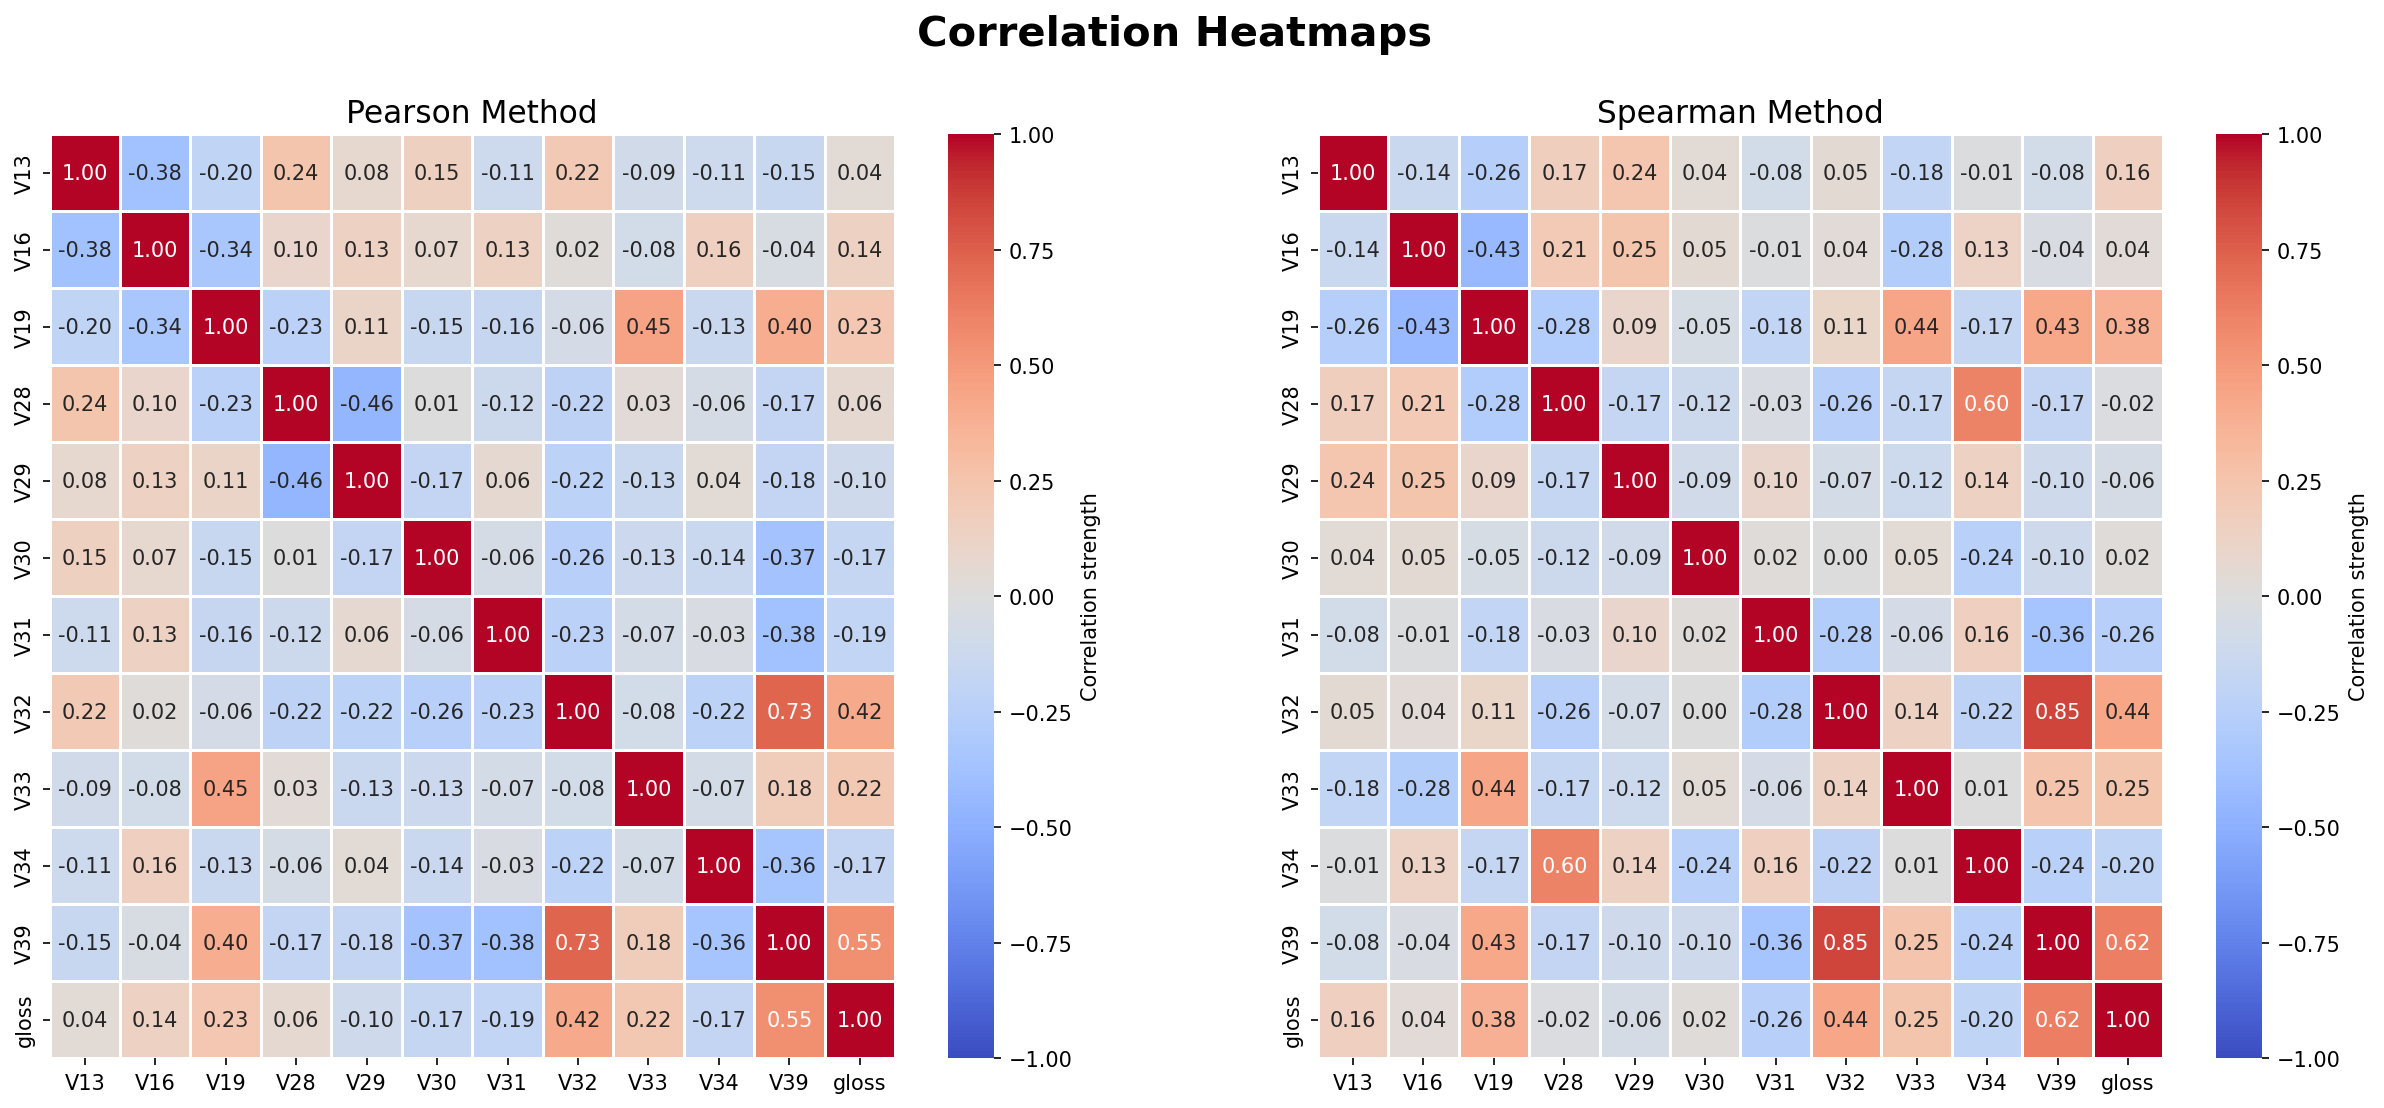

In [18]:
# --------------------------------------------------------
# Correlation matrices (numeric only to avoid errors)
# --------------------------------------------------------
pearson_corr = data.corr(method="pearson", numeric_only=True)
spearman_corr = data.corr(method="spearman", numeric_only=True)

# --------------------------------------------------------
# Visualization with different style
# --------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi=150)
fig.subplots_adjust(wspace=0.2, hspace=0.25)
fig.suptitle("Correlation Heatmaps", fontsize=20, fontweight="bold")

# Pearson correlation heatmap
sns.heatmap(
    pearson_corr, ax=axes[0],
    linewidths=0.5, annot=True,
    cmap="coolwarm", center=0,
    vmin=-1, vmax=1, fmt=".2f",
    cbar_kws={'label': 'Correlation strength'}
)
axes[0].set_title("Pearson Method", fontsize=15)

# Spearman correlation heatmap
sns.heatmap(
    spearman_corr, ax=axes[1],
    linewidths=0.5, annot=True,
    cmap="coolwarm", center=0,
    vmin=-1, vmax=1, fmt=".2f",
    cbar_kws={'label': 'Correlation strength'}
)
axes[1].set_title("Spearman Method", fontsize=15)

plt.show()


In [19]:
# --------------------------------------------------------
# Parameters
# --------------------------------------------------------
random_seed = 1
test_fraction = 0.10   # use 10% of the dataset for testing

# --------------------------------------------------------
# Separate target and features
# --------------------------------------------------------
target = data.iloc[:, -1]           # last column = target
features = data.iloc[:, :-1]        # everything else = predictors

# --------------------------------------------------------
# One-Hot Encoding for categorical variables
# --------------------------------------------------------
# Identify categorical columns (dtype = object)
categorical_idx = np.where(features.dtypes == "object")[0]

# Apply one-hot encoding (drop first to avoid dummy trap)
transformer = ColumnTransformer(
    transformers=[("ohe", OneHotEncoder(drop="first"), categorical_idx)],
    remainder="passthrough"
)
features_encoded = transformer.fit_transform(features)

# Collect feature names
feature_names = transformer.get_feature_names_out()
target_name = data.columns[-1]
n_samples, n_features = features_encoded.shape

print(f"Target column: \n{target_name}\n")
print(f"Feature columns ({n_features}): \n{np.array(feature_names)}\n")

# --------------------------------------------------------
# Split into training/validation and test sets
# --------------------------------------------------------
X_train_val, X_test, y_train_val, y_test = train_test_split(
    features_encoded, target,
    test_size=test_fraction,
    random_state=random_seed,
    shuffle=True
)

# --------------------------------------------------------
# Standardization (z-score normalization)
# --------------------------------------------------------
scaler = StandardScaler()

X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)   # use train statistics!

# --------------------------------------------------------
# Handle outliers
# --------------------------------------------------------
# Exclude samples where target > 11,000 (hard to predict)
mask_normal = y_train_val < 11000

# "without outliers" sets
X_train_val_scaled_clean = X_train_val_scaled[mask_normal.values, :]
X_train_val_clean = X_train_val[mask_normal.values, :]
y_train_val_clean = y_train_val[mask_normal.values]

# "outlier only" sets
X_outliers_scaled = X_train_val_scaled[~mask_normal.values, :]
X_train_val_outliers = X_train_val[~mask_normal.values, :]
y_train_val_outliers = y_train_val[~mask_normal.values]

Target column: 
gloss

Feature columns (35): 
['ohe__V15_HMW 2' 'ohe__V15_HMW 3' 'ohe__V15_HMW 4' 'ohe__V15_HMW 5'
 'ohe__V15_HMW 6' 'ohe__V15_LMW 1' 'ohe__V15_LMW 2' 'ohe__V15_LMW 3'
 'ohe__V18_HMW 3' 'ohe__V18_HMW 4' 'ohe__V18_HMW 5' 'ohe__V18_HMW 6'
 'ohe__V18_LMW 1' 'ohe__V18_LMW 2' 'ohe__V18_LMW 4' 'ohe__V18_LMW 5'
 'ohe__V18_LMW 6' 'ohe__V18_MMW 1' 'ohe__V18_MMW 2' 'ohe__V18_nan'
 'ohe__V21_LMW 3' 'ohe__V21_LMW 6' 'ohe__V21_LMW 7' 'ohe__V21_nan'
 'remainder__V13' 'remainder__V16' 'remainder__V19' 'remainder__V28'
 'remainder__V29' 'remainder__V30' 'remainder__V31' 'remainder__V32'
 'remainder__V33' 'remainder__V34' 'remainder__V39']



In [20]:
from sklearn import metrics

# --------------------------------------------------------
# Function to compute model predictions and error metrics
# --------------------------------------------------------
def evaluate_model(model, X_train, X_test, X_outliers, y_train, y_test):
    """
    Evaluate regression model performance and return predictions + errors.
    """

    # Predictions for outlier set (if available)
    if len(X_outliers) > 0:
        y_pred_outliers = model.predict(X_outliers)
    else:
        y_pred_outliers = np.array([])

    # Predictions on train/validation and test sets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Residuals (errors)
    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test

    # Error metrics
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test  = metrics.mean_squared_error(y_test, y_pred_test, squared=False)

    r2_train = metrics.r2_score(y_train, y_pred_train)
    r2_test  = metrics.r2_score(y_test, y_pred_test)

    # Normalized RMSE (custom formula)
    nrmse_train = 1 - np.sqrt(abs(r2_train - 1))
    nrmse_test  = 1 - np.sqrt(abs(r2_test - 1))

    # Organize results into dictionaries
    rmse_dict  = {"Train+Val": rmse_train, "Test": rmse_test}
    r2_dict    = {"Train+Val": r2_train,   "Test": r2_test}
    nrmse_dict = {"Train+Val": nrmse_train,"Test": nrmse_test}

    errors = {"RMSE": rmse_dict, "R2": r2_dict, "NRMSE": nrmse_dict}

    return model, y_pred_train, y_pred_test, y_pred_outliers, residuals_train, residuals_test, errors


# --------------------------------------------------------
# Function to visualize results
# --------------------------------------------------------
def plot_results(title, y_train, y_test, y_outliers, y_pred_train, y_pred_test, y_pred_outliers, res_train, res_test):
    """
    Create comparison plots: predictions vs actuals, error histograms, residuals.
    """

    # Handle outlier presence
    if len(y_outliers) == 0 and len(y_pred_outliers) == 0:
        y_outliers = np.nan
        y_pred_outliers = np.nan
        ymin = np.floor(np.min([y_train.min(), y_pred_train.min(), y_pred_test.min()]) / 1000) * 1000
        ymax = np.ceil(np.max([y_train.max(), y_pred_train.max(), y_pred_test.max()]) / 1000) * 1000
    else:
        ymin = np.floor(np.min([y_train.min(), y_pred_train.min(), y_pred_test.min(), np.min(y_pred_outliers)]) / 1000) * 1000
        ymax = np.ceil(np.max([y_train.max(), y_pred_train.max(), y_pred_test.max(), np.max(y_pred_outliers)]) / 1000) * 1000

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=140)
    fig.subplots_adjust(wspace=0.4, hspace=0.25)
    fig.suptitle(title, fontsize=12, fontweight="bold")

    # -----------------------
    # (1) Predictions vs Actual
    # -----------------------
    axes[0].scatter(y_train, y_pred_train, s=10, alpha=0.6, label="Train+Val")
    axes[0].scatter(y_test, y_pred_test, s=10, alpha=0.6, label="Test")
    if np.size(y_outliers) > 1 or ~np.isnan(y_outliers):
        axes[0].scatter(y_outliers, y_pred_outliers, s=10, alpha=0.6, label="Removed outliers", c="red")

    axes[0].plot([ymin, ymax], [ymin, ymax], "k--", lw=0.8)
    axes[0].set_xlabel("Actual values")
    axes[0].set_ylabel("Predicted values")
    axes[0].set_xlim([ymin, ymax])
    axes[0].set_ylim([ymin, ymax])
    axes[0].legend(loc="upper left", fontsize=7)

    # -----------------------
    # (2) Histogram of residuals
    # -----------------------
    axes[1].hist(res_train, density=True, bins="auto", alpha=0.7, label="Train+Val")
    axes[1].hist(res_test, density=True, bins="auto", alpha=0.5, label="Test")
    axes[1].set_xlabel("Residuals")
    axes[1].set_ylabel("Relative frequency")
    axes[1].legend(loc="upper left", fontsize=7)

    # -----------------------
    # (3) Residuals vs sample index
    # -----------------------
    axes[2].plot(y_train.index, res_train, ".", alpha=0.6, label="Train+Val")
    axes[2].plot(y_test.index, res_test, ".", alpha=0.6, label="Test")
    axes[2].set_xlabel("Sample index")
    axes[2].set_ylabel("Residuals")
    axes[2].legend(loc="upper left", fontsize=7)

    plt.show()

In [21]:
# --------------------------------------------------------
# OLS with automatic feature elimination
# --------------------------------------------------------
def run_ols_with_reduction(feature_names, X_train, X_test, X_outliers, y_train, y_test):
    """
    Perform iterative OLS regression, removing features with the highest p-value
    until all remaining predictors are statistically significant (p < 0.05).
    """

    # Keep a copy of feature names
    if len(feature_names) != 0:
        names_for_ols = feature_names.copy()
    else:
        names_for_ols = [f"x{i}" for i in range(1, X_train.shape[1] + 1)]

    # Add intercept to training/test data
    X_train_wc = sm.add_constant(X_train, has_constant="add")
    X_test_wc  = sm.add_constant(X_test, has_constant="add")

    # Outlier set handling
    if len(X_outliers) > 0:
        X_outliers_wc = sm.add_constant(X_outliers, has_constant="add")
    else:
        X_outliers_wc = []

    repeat = True
    removed_features = []

    # Iteratively remove predictors with the worst p-value
    while repeat:
        model = sm.OLS(y_train, X_train_wc)
        model.exog_names[1:] = names_for_ols  # attach column names

        model = model.fit()

        results, y_pred_train, y_pred_test, y_pred_out, res_train, res_test, metrics_dict = evaluate_model(
            model, X_train_wc, X_test_wc, X_outliers_wc, y_train, y_test
        )

        # Extract p-values
        p_values = model.summary2().tables[1]["P>|t|"]

        if p_values.max() <= 0.05:
            # Stop if all predictors are significant
            repeat = False
        else:
            # Remove the variable with the highest p-value
            worst_idx = np.where(p_values == p_values.max())[0]
            names_for_ols = np.delete(names_for_ols, worst_idx - 1)
            X_train_wc = np.delete(X_train_wc, worst_idx, axis=1)
            X_test_wc  = np.delete(X_test_wc,  worst_idx, axis=1)
            if len(X_outliers) > 0:
                X_outliers_wc = np.delete(X_outliers_wc, worst_idx, axis=1)
            removed_features.append(worst_idx)

    # Print statistical summary
    print(model.summary())

    final_num_features = len(p_values) - 1   # subtract constant

    return final_num_features, X_train_wc, X_test_wc, X_outliers_wc, y_pred_train, y_pred_test, y_pred_out, res_train, res_test, metrics_dict


# --------------------------------------------------------
# Compact printing of results
# --------------------------------------------------------
def show_model_performance(model_name, num_features, error_dict, note=""):
    """
    Print performance metrics in a formatted line.
    """
    print(
        f"{model_name:>15}: {num_features:6d} | "
        f"{error_dict['R2']['Train+Val']:10.3f} | {error_dict['R2']['Test']:10.3f} | "
        f"{error_dict['RMSE']['Train+Val']:11.3f} | {error_dict['RMSE']['Test']:11.3f} | "
        f"{error_dict['NRMSE']['Train+Val']:12.3f} | {error_dict['NRMSE']['Test']:12.3f} | "
        f"{note}"
    )

In [23]:
def evaluate_model(model, X_train, X_test, X_outliers, y_train, y_test):
    """
    Evaluate regression model performance and return predictions + errors.
    """

    # Predictions for outlier set (if available)
    if len(X_outliers) > 0:
        y_pred_outliers = model.predict(X_outliers)
    else:
        y_pred_outliers = np.array([])

    # Predictions on train/validation and test sets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Residuals (errors)
    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test

    # Error metrics
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    rmse_test  = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))

    r2_train = metrics.r2_score(y_train, y_pred_train)
    r2_test  = metrics.r2_score(y_test, y_pred_test)

    # Normalized RMSE (custom formula)
    nrmse_train = 1 - np.sqrt(abs(r2_train - 1))
    nrmse_test  = 1 - np.sqrt(abs(r2_test - 1))

    # Organize results into dictionaries
    rmse_dict  = {"Train+Val": rmse_train, "Test": rmse_test}
    r2_dict    = {"Train+Val": r2_train,   "Test": r2_test}
    nrmse_dict = {"Train+Val": nrmse_train,"Test": nrmse_test}

    errors = {"RMSE": rmse_dict, "R2": r2_dict, "NRMSE": nrmse_dict}

    return model, y_pred_train, y_pred_test, y_pred_outliers, residuals_train, residuals_test, errors

In [26]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn import metrics
import numpy as np

# --------------------------------------------------------
# Function: Lasso cross-validation search for optimal alpha
# --------------------------------------------------------
def run_lasso_cv(X_train, y_train, n_splits=5, alpha_min=0, alpha_max=np.log10(1000)):
    """
    Perform Lasso regression over a range of alphas using K-Fold CV.
    Returns coefficient paths, errors, and optimal alpha/features.
    """
    # Prepare alpha values on log scale
    alphas = np.logspace(alpha_min, alpha_max, num=int(np.ceil(alpha_max * 100 + 1)))

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=rnd_state)

    coefs_all = []
    rmse_train_mean, rmse_train_std = [], []
    rmse_val_mean, rmse_val_std = [], []

    r2_train_mean, r2_train_std = [], []
    r2_val_mean, r2_val_std = [], []

    nrmse_train_mean, nrmse_train_std = [], []
    nrmse_val_mean, nrmse_val_std = [], []

    # Iterate over alphas
    for alpha in alphas:
        coefs_fold = []
        rmse_tr_fold, rmse_val_fold = [], []
        r2_tr_fold, r2_val_fold = [], []
        nrmse_tr_fold, nrmse_val_fold = [], []

        for train_idx, val_idx in kf.split(X_train):
            X_tr, X_val = X_train[train_idx,:], X_train[val_idx,:]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Fit Lasso
            model = Lasso(alpha=alpha, max_iter=10000)
            model.fit(X_tr, y_tr)

            # Predictions
            y_tr_pred = model.predict(X_tr)
            y_val_pred = model.predict(X_val)

            # Store coefficients
            coefs_fold.append(model.coef_)

            # Compute metrics
            rmse_tr_fold.append(np.sqrt(metrics.mean_squared_error(y_tr, y_tr_pred)))
            rmse_val_fold.append(np.sqrt(metrics.mean_squared_error(y_val, y_val_pred)))

            r2_tr_fold.append(metrics.r2_score(y_tr, y_tr_pred))
            r2_val_fold.append(metrics.r2_score(y_val, y_val_pred))

            nrmse_tr_fold.append(1 - np.sqrt(abs(r2_tr_fold[-1] - 1)))
            nrmse_val_fold.append(1 - np.sqrt(abs(r2_val_fold[-1] - 1)))

        # Aggregate metrics across folds
        coefs_all.append(np.mean(np.array(coefs_fold), axis=0))
        rmse_train_mean.append(np.mean(rmse_tr_fold))
        rmse_train_std.append(np.std(rmse_tr_fold, ddof=1))
        rmse_val_mean.append(np.mean(rmse_val_fold))
        rmse_val_std.append(np.std(rmse_val_fold, ddof=1))
        r2_train_mean.append(np.mean(r2_tr_fold))
        r2_train_std.append(np.std(r2_tr_fold, ddof=1))
        r2_val_mean.append(np.mean(r2_val_fold))
        r2_val_std.append(np.std(r2_val_fold, ddof=1))
        nrmse_train_mean.append(np.mean(nrmse_tr_fold))
        nrmse_train_std.append(np.std(nrmse_tr_fold, ddof=1))
        nrmse_val_mean.append(np.mean(nrmse_val_fold))
        nrmse_val_std.append(np.std(nrmse_val_fold, ddof=1))

    coefs_all = np.array(coefs_all)

    # --------------------------------------------------------
    # Determine optimal alpha using minimal validation RMSE with 5% tolerance
    # --------------------------------------------------------
    e_tol = 0.05  # 5% tolerance
    idx_min = np.argmin(rmse_val_mean)
    min_rmse_val = rmse_val_mean[idx_min]

    # Tolerated index (last alpha within 5% of min error)
    idx_tol = idx_min + np.argmin(np.abs(np.array(rmse_val_mean[idx_min:]) - min_rmse_val*(1+e_tol)))
    
    alpha_opt = alphas[idx_tol]
    n_features_opt = np.sum(coefs_all[idx_tol,:] != 0)

    return alphas, coefs_all, rmse_train_mean, rmse_train_std, rmse_val_mean, rmse_val_std, alpha_opt, n_features_opt


# --------------------------------------------------------
# Apply Lasso with and without outliers
# --------------------------------------------------------
alphas, coefs, rmse_tr_m, rmse_tr_s, rmse_val_m, rmse_val_s, alpha_opt_with, n_feat_with = run_lasso_cv(X_TrVal_z, y_TrVal)
alphas, coefs, rmse_tr_m, rmse_tr_s, rmse_val_m, rmse_val_s, alpha_opt_without, n_feat_without = run_lasso_cv(X_TrVal_z_woo, y_TrVal_woo)

# Fit final Lasso models using optimal alpha
lasso_with = Lasso(alpha=alpha_opt_with, max_iter=10000).fit(X_TrVal_z, y_TrVal)
lasso_without = Lasso(alpha=alpha_opt_without, max_iter=10000).fit(X_TrVal_z_woo, y_TrVal_woo)

# Compute predictions and errors
results_with, y_pred_tr_with, y_pred_test_with, y_pred_out_with, res_tr_with, res_test_with, lasso_metrics_with = evaluate_model(
    lasso_with, X_TrVal_z, X_T_z, [], y_TrVal, y_T
)

results_without, y_pred_tr_without, y_pred_test_without, y_pred_out_without, res_tr_without, res_test_without, lasso_metrics_without = evaluate_model(
    lasso_without, X_TrVal_z_woo, X_T_z, X_o_z, y_TrVal_woo, y_T
)

# --------------------------------------------------------
# Print results table
# --------------------------------------------------------
print("\n\nModel Summary | Features | R2 (Train) | R2 (Test) | RMSE (Train) | RMSE (Test) | NRMSE (Train) | NRMSE (Test) | Comment")
show_model_performance("Lasso", n_feat_with, lasso_metrics_with, "with outliers")
show_model_performance("Lasso", n_feat_without, lasso_metrics_without, "without outliers")

# --------------------------------------------------------
# Plots
# --------------------------------------------------------
plot_regression("Lasso Regression (with outliers)", y_TrVal, y_T, [], y_pred_tr_with, y_pred_test_with, [], res_tr_with, res_test_with)
plot_regression("Lasso Regression (without outliers)", y_TrVal_woo, y_T, y_TrVal_o, y_pred_tr_without, y_pred_test_without, y_pred_out_without, res_tr_without, res_test_without)

NameError: name 'X_TrVal_z' is not defined

In [1]:
# ----------------------------
# 1. Imports
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
from sklearn import metrics
import statsmodels.api as sm


In [2]:

# ----------------------------
# 2. Load data
# ----------------------------
df_raw = pd.read_excel("Aufgabe_1_Gloss_Optimization.xlsx")
pd.set_option('display.expand_frame_repr', False)
print(f"Dataset dimensions: {df_raw.shape}")
print(df_raw.tail())

Dataset dimensions: (58, 15)
    V13    V15  V16    V18  V19    V21       V28       V29       V30       V31       V32       V33       V34  V39  gloss
53  0.2  HMW 1  0.2  HMW 6  0.0    NaN  0.217525  0.195159  0.005929  0.018465 -0.006291  0.002313  0.017525    5   4800
54  0.4  HMW 5  0.0    NaN  0.0    NaN  0.394731 -0.022175 -0.013080 -0.003039 -0.035266 -0.009641 -0.005269    5   6000
55  0.4  HMW 6  0.0    NaN  0.0    NaN  0.414315 -0.006811 -0.007612  0.012732 -0.000735 -0.001841  0.014315    5   4700
56  0.2  HMW 5  0.2  LMW 6  0.0    NaN  0.207545 -0.002715 -0.000442 -0.006795  0.000325  0.203296  0.007545    6   8000
57  0.2  HMW 1  0.1  LMW 6  0.1  LMW 1  0.011453  0.204203 -0.005749 -0.000304  0.090017  0.117056  0.011453    8   7300


In [3]:

# ----------------------------
# 3. Features / target / encoding
# ----------------------------
y = df_raw.iloc[:,-1]
X_raw = df_raw.iloc[:, :-1]

# Identify categorical columns
cat_idx = np.where(X_raw.dtypes == object)[0]

# One-hot encoding for categorical features
ct = ColumnTransformer([('encoder', OneHotEncoder(drop='first'), cat_idx)], remainder='passthrough')
X_encoded = ct.fit_transform(X_raw)
feature_names = ct.get_feature_names_out()


In [4]:

# ----------------------------
# 4. Train/Test split & scaling
# ----------------------------
rnd_state = 1
X_train_val, X_test, y_train_val, y_test = train_test_split(X_encoded, y, test_size=0.1, random_state=rnd_state, shuffle=True)

scaler = StandardScaler()
X_train_val_z = scaler.fit_transform(X_train_val)
X_test_z = scaler.transform(X_test)

In [14]:
# ----------------------------
# 5. Outlier removal (target > 11000)
# ----------------------------
mask = y_train_val < 11000
X_train_val_clean_z = X_train_val_z[mask.values, :]
y_train_val_clean = y_train_val[mask.values]

X_outliers_z = X_train_val_z[~mask.values, :]
y_outliers = y_train_val[~mask.values]


In [15]:
# Core libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates as mdates
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

# Machine Learning tools
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, HuberRegressor
from sklearn.svm import SVR
from sklearn import metrics

# Additional utilities
import statsmodels.api as sm
from itertools import cycle
from multiprocessing import cpu_count
import copy


In [16]:

# --- Load data ---
df_raw = pd.read_excel("Aufgabe_1_Gloss_Optimization.xlsx")

# Show full width without wrapping
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# Custom figure style (warm tone, larger default size)
plt.style.use("seaborn-v0_8-deep")
plt.rcParams["figure.figsize"] = (8, 5)

# Output dataset info
rows, cols = df_raw.shape
print(f'Dataset "Gloss_Optimization" dimensions: {rows} rows × {cols} columns\n')
df_raw.head(11)

Dataset "Gloss_Optimization" dimensions: 58 rows × 15 columns



,V13,V15,V16,V18,V19,V21,V28,V29,V30,V31,V32,V33,V34,V39,gloss
0,0.10,HMW 1,0.05,LMW 1,0.05,LMW 6,-0.004681,0.103880,0.000972,-0.005881,0.055534,0.058750,-0.004681,8,6200
1,0.12,HMW 1,0.04,LMW 1,0.04,LMW 6,-0.010345,0.112653,0.001479,0.005503,0.040954,0.056777,-0.010345,8,6400
2,0.12,HMW 1,0.06,LMW 1,0.02,LMW 6,-0.005359,0.125634,0.003815,-0.012599,0.074109,0.015341,-0.005359,8,5800
3,0.14,HMW 1,0.04,LMW 1,0.02,LMW 6,-0.004240,0.147946,-0.016650,0.010005,0.039433,0.018663,-0.004240,6,6200
4,0.28,HMW 1,0.08,LMW 1,0.04,LMW 6,-0.026882,0.284841,-0.009568,-0.019216,0.068883,0.038201,-0.026882,8,8600
5,0.12,HMW 1,0.06,LMW 1,0.02,LMW 7,-0.012378,0.131851,-0.009754,0.003244,0.059373,0.026450,-0.012378,8,4800
6,0.24,HMW 1,0.12,LMW 1,0.04,LMW 7,-0.003660,0.244951,0.016939,-0.012309,0.123884,0.042937,-0.003660,8,6800
7,0.14,HMW 1,0.04,LMW 1,0.02,LMW 7,0.006664,0.125695,-0.004785,-0.004625,0.037321,0.018528,0.006664,6,4000
8,0.28,HMW 1,0.08,LMW 1,0.04,LMW 7,0.018571,0.288215,-0.007519,0.003315,0.079077,0.046381,0.018571,8,6600
9,0.10,HMW 1,0.05,LMW 1,0.05,LMW 3,0.007331,0.103919,0.002864,-0.014808,0.067368,0.005788,0.007331,8,7300


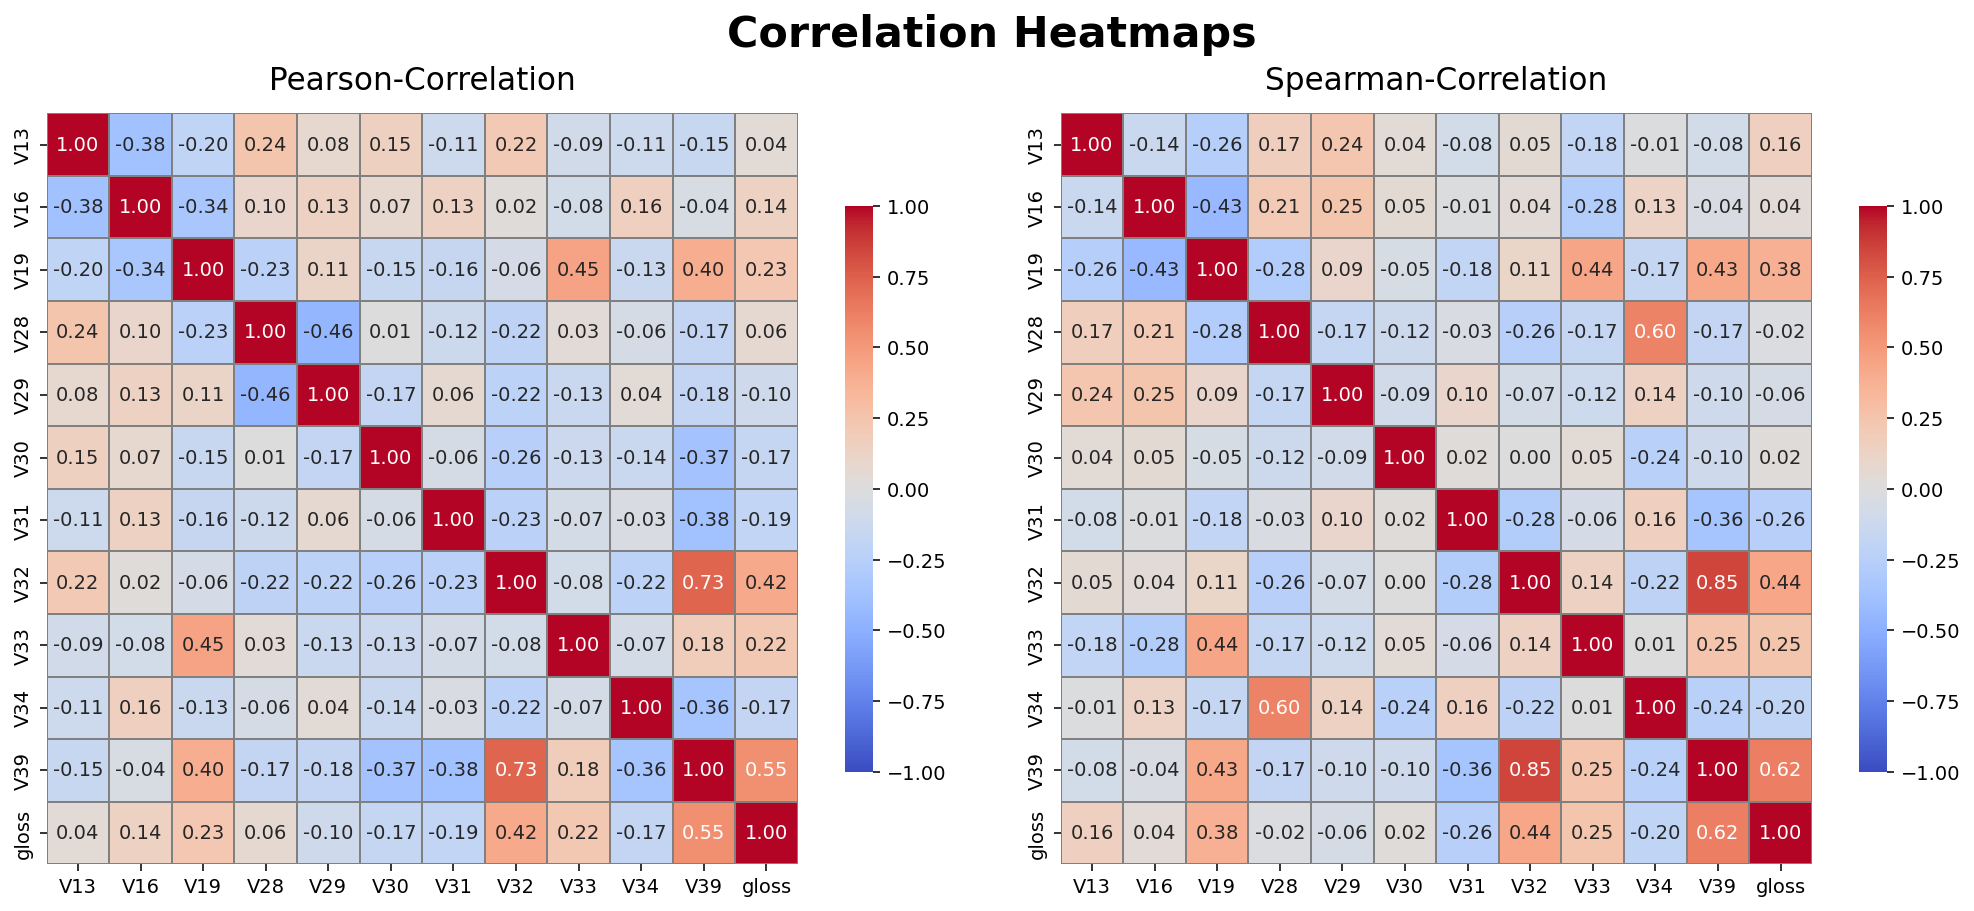

In [17]:
# --- Select numeric columns only ---
numeric_df = df_raw.select_dtypes(include=[np.number])

# --- Correlation calculation ---
methods = ["pearson", "spearman"]
correlation_matrices = {m: numeric_df.corr(method=m) for m in methods}

# --- Plot ---
fig, axes = plt.subplots(ncols=2, figsize=(18, 7), dpi=140)
fig.suptitle("Correlation Heatmaps", fontsize=22, fontweight="bold")
plt.subplots_adjust(wspace=0.08)

color_map = "coolwarm"

for ax, method in zip(axes, methods):
    sns.heatmap(
        correlation_matrices[method],
        ax=ax,
        annot=True,
        cmap=color_map,
        linewidths=0.8,
        linecolor="gray",
        fmt=".2f",
        vmin=-1,
        vmax=1,
        square=True,
        cbar_kws={"shrink": 0.75}
    )
    ax.set_title(f"{method.capitalize()}‑Correlation", fontsize=16, pad=12)

plt.show()

In [18]:
# --- Parameters ---
RANDOM_STATE = 1
TEST_RATIO = 0.10

# --- Separate target and features ---
target_col = df_raw.columns[-1]
y = df_raw[target_col]
X_raw = df_raw.drop(columns=target_col)

# --- Identify categorical (object) columns for encoding ---
cat_cols = X_raw.select_dtypes(include=["object"]).columns.tolist()

# --- One-Hot Encoding with ColumnTransformer ---
encoder = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), cat_cols)
    ],
    remainder="passthrough"
)
X_encoded = encoder.fit_transform(X_raw)

# --- Headers for transformed data ---
X_headers = encoder.get_feature_names_out()
n_rows, n_cols = X_encoded.shape

print(f"Target (y) column:\n{target_col}\n")
print(f"Feature columns ({n_cols}):\n{np.array(X_headers)}\n")

# --- Train/Test split ---
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_encoded, y,
    test_size=TEST_RATIO,
    random_state=RANDOM_STATE,
    shuffle=True
)

# --- Standardize based on train/val only ---
scaler = StandardScaler()
X_train_val_z = scaler.fit_transform(X_train_val)
X_test_z = scaler.transform(X_test)

# --- Outlier filtering (values < 11,000) ---
mask_inlier = y_train_val < 11000
X_train_val_z_in = X_train_val_z[mask_inlier]
X_train_val_in = X_train_val[mask_inlier]
y_train_val_in = y_train_val[mask_inlier]

X_train_val_z_out = X_train_val_z[~mask_inlier]
X_train_val_out = X_train_val[~mask_inlier]
y_train_val_out = y_train_val[~mask_inlier]

Target (y) column:
gloss

Feature columns (35):
['ohe__V15_HMW 2' 'ohe__V15_HMW 3' 'ohe__V15_HMW 4' 'ohe__V15_HMW 5'
 'ohe__V15_HMW 6' 'ohe__V15_LMW 1' 'ohe__V15_LMW 2' 'ohe__V15_LMW 3'
 'ohe__V18_HMW 3' 'ohe__V18_HMW 4' 'ohe__V18_HMW 5' 'ohe__V18_HMW 6'
 'ohe__V18_LMW 1' 'ohe__V18_LMW 2' 'ohe__V18_LMW 4' 'ohe__V18_LMW 5'
 'ohe__V18_LMW 6' 'ohe__V18_MMW 1' 'ohe__V18_MMW 2' 'ohe__V18_nan'
 'ohe__V21_LMW 3' 'ohe__V21_LMW 6' 'ohe__V21_LMW 7' 'ohe__V21_nan'
 'remainder__V13' 'remainder__V16' 'remainder__V19' 'remainder__V28'
 'remainder__V29' 'remainder__V30' 'remainder__V31' 'remainder__V32'
 'remainder__V33' 'remainder__V34' 'remainder__V39']



In [19]:
from math import floor, ceil

def compute_error_metrics(model, X_train, X_test, X_out, y_train, y_test):
    """Calculate predictions, residuals, and common regression error metrics."""
    y_pred_out = model.predict(X_out) if len(X_out) else np.nan
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    errors_train = y_train - y_pred_train
    errors_test = y_test - y_pred_test

    # Helper to compute RMSE, R², and NRMSE
    rmse = {lbl: metrics.mean_squared_error(
                y, y_hat, squared=False
            ) for lbl, y, y_hat in [
                ("TrainVal", y_train, y_pred_train),
                ("Test", y_test, y_pred_test)
            ]}

    r2 = {lbl: metrics.r2_score(y, y_hat)
          for lbl, y, y_hat in [
              ("TrainVal", y_train, y_pred_train),
              ("Test", y_test, y_pred_test)
          ]}

    nrmse = {k: 1 - np.sqrt(abs(v - 1)) for k, v in r2.items()}

    return model, y_pred_train, y_pred_test, y_pred_out, errors_train, errors_test, {
        "RMSE": rmse,
        "NRMSE": nrmse,
        "R2": r2
    }

def plot_results(title, y_train, y_test, y_out, y_pred_train, y_pred_test, y_pred_out, err_train, err_test):
    """Visualize predicted vs actual, error histograms, and residuals over index."""
    # Determine min/max range rounded to nearest 1000
    valid_vals = [y_train, y_pred_train, y_test, y_pred_test]
    if np.size(y_out) > 0 and not np.isnan(np.sum(y_out)):
        valid_vals.extend([y_pred_out, y_out])
    y_min = floor(np.min([np.min(v) for v in valid_vals]) / 1000) * 1000
    y_max = ceil(np.max([np.max(v) for v in valid_vals]) / 1000) * 1000

    fig, axes = plt.subplots(1, 3, figsize=(11, 3), dpi=150)
    fig.suptitle(title, fontsize=14, fontweight="bold")

    # Scatter: predicted vs actual
    axes[0].plot([y_min, y_max], [y_min, y_max], color="black", lw=0.8)
    axes[0].scatter(y_train, y_pred_train, alpha=0.6, label="Train+Val", s=15)
    axes[0].scatter(y_test, y_pred_test, alpha=0.6, label="Test", s=15)
    if np.size(y_out) > 1 and not np.isnan(np.sum(y_out)):
        axes[0].scatter(y_out, y_pred_out, alpha=0.5, label="Removed Outliers", color="crimson", s=15)
    axes[0].set(xlabel="Measurement", ylabel="Model", xlim=(y_min, y_max), ylim=(y_min, y_max))
    axes[0].legend(fontsize=6, loc="upper left")

    # Histogram of errors
    axes[1].hist(err_train, density=True, bins="auto", label="Train+Val", alpha=0.7)
    axes[1].hist(err_test, density=True, bins="auto", label="Test", alpha=0.5)
    axes[1].set(xlabel="Residual", ylabel="Relative Frequency")
    axes[1].legend(fontsize=6, loc="upper left")

    # Residuals over index
    axes[2].scatter(y_train.index, err_train, s=10, label="Train+Val")
    axes[2].scatter(y_test.index, err_test, s=10, label="Test")
    axes[2].set(xlabel="Index", ylabel="y - ŷ")
    axes[2].legend(fontsize=6, loc="upper left")

    plt.tight_layout()
    plt.show()

In [20]:
def compute_error_metrics(model, X_train, X_test, X_out, y_train, y_test):
    """Calculate predictions, residuals, and common regression error metrics."""
    # Predictions
    y_pred_out = model.predict(X_out) if len(X_out) else np.nan
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Residuals
    errors_train = y_train - y_pred_train
    errors_test = y_test - y_pred_test

    # RMSE (manual sqrt to avoid 'squared' param issues)
    rmse = {
        lbl: np.sqrt(metrics.mean_squared_error(y, y_hat))
        for lbl, y, y_hat in [
            ("TrVal", y_train, y_pred_train),
            ("Test", y_test, y_pred_test)
        ]
    }

    # R²
    r2 = {
        lbl: metrics.r2_score(y, y_hat)
        for lbl, y, y_hat in [
            ("TrVal", y_train, y_pred_train),
            ("Test", y_test, y_pred_test)
        ]
    }

    # NRMSE
    nrmse = {
        lbl: 1 - np.sqrt(abs(r2_val - 1))
        for lbl, r2_val in [
            ("TrVal", r2["TrVal"]),
            ("Test", r2["Test"])
        ]
    }

    return model, y_pred_train, y_pred_test, y_pred_out, errors_train, errors_test, {
        "RMSE": rmse,
        "NRMSE": nrmse,
        "R2": r2
    }

In [22]:

def run_lasso_cv(X_train_val, y_train_val, random_state=42):
    """
    Perform Lasso regression with a range of alpha values using K-Fold cross-validation.
    Returns:
        alphas_lasso, coefs_lasso, rmse_tr_mean, rmse_tr_std, rmse_val_mean, rmse_val_std,
        optimal_alpha, n_features_selected
    """

    # Search space for alpha values
    a_min = 0
    a_max = np.log10(1000)
    alphas_lasso = np.logspace(a_min, a_max, int(np.ceil(a_max * 100 + 1)))

    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

    # Tracking results
    coefs_lasso     = []
    rmse_tr_mean    = []
    rmse_tr_std     = []
    rmse_val_mean   = []
    rmse_val_std    = []
    r2_tr_mean      = []
    r2_tr_std       = []
    r2_val_mean     = []
    r2_val_std      = []
    nrmse_tr_mean   = []
    nrmse_tr_std    = []
    nrmse_val_mean  = []
    nrmse_val_std   = []

    for alpha in alphas_lasso:
        rmse_tr, rmse_val = [], []
        r2_tr, r2_val     = [], []
        nrmse_tr, nrmse_val = [], []
        temp_coef         = []

        for idx_train, idx_val in kf.split(X_train_val):
            # Split fold
            X_tr, X_val = X_train_val[idx_train, :], X_train_val[idx_val, :]
            y_tr = y_train_val.iloc[idx_train]
            y_val = y_train_val.iloc[idx_val]

            # Fit Lasso
            clf = Lasso(alpha=alpha, max_iter=10000)
            clf.fit(X_tr, y_tr)

            # Predict
            y_pred_tr = clf.predict(X_tr)
            y_pred_val = clf.predict(X_val)

            # Store coefficients
            temp_coef.append(clf.coef_)

            # Metrics
            rmse_tr.append(metrics.mean_squared_error(y_tr, y_pred_tr, squared=False))
            rmse_val.append(metrics.mean_squared_error(y_val, y_pred_val, squared=False))
            r2_tr.append(metrics.r2_score(y_tr, y_pred_tr))
            r2_val.append(metrics.r2_score(y_val, y_pred_val))
            nrmse_tr.append(1 - np.sqrt(abs(r2_tr[-1] - 1)))
            nrmse_val.append(1 - np.sqrt(abs(r2_val[-1] - 1)))

        # Store fold-averaged metrics
        rmse_tr_mean.append(np.mean(rmse_tr))
        rmse_tr_std.append(np.std(rmse_tr, ddof=1))
        rmse_val_mean.append(np.mean(rmse_val))
        rmse_val_std.append(np.std(rmse_val, ddof=1))
        r2_tr_mean.append(np.mean(r2_tr))
        r2_tr_std.append(np.std(r2_tr, ddof=1))
        r2_val_mean.append(np.mean(r2_val))
        r2_val_std.append(np.std(r2_val, ddof=1))
        nrmse_tr_mean.append(np.mean(nrmse_tr))
        nrmse_tr_std.append(np.std(nrmse_tr, ddof=1))
        nrmse_val_mean.append(np.mean(nrmse_val))
        nrmse_val_std.append(np.std(nrmse_val, ddof=1))
        coefs_lasso.append(np.mean(np.array(temp_coef), axis=0))

    coefs_lasso = np.array(coefs_lasso)

    # Select optimal alpha within tolerance
    error_tolerance_pct = 5
    val_rmse_min = np.min(rmse_val_mean)
    idx_best_rmse = np.where(rmse_val_mean == val_rmse_min)[0][-1]

    val_rmse_diff = abs(np.array(rmse_val_mean[idx_best_rmse:]) -
                        val_rmse_min * (1 + error_tolerance_pct / 100))
    idx_tol = np.where(val_rmse_diff == np.min(val_rmse_diff))[0][-1]

    idx_optimal = idx_best_rmse + idx_tol
    optimal_alpha = alphas_lasso[idx_optimal]
    n_features_selected = np.sum(coefs_lasso[idx_optimal, :] != 0)

    return (alphas_lasso, coefs_lasso, rmse_tr_mean, rmse_tr_std,
            rmse_val_mean, rmse_val_std, optimal_alpha, n_features_selected)



In [24]:

# --- Run for both scenarios ---
alphas, coefs, rmse_tr_m, rmse_tr_s, rmse_val_m, rmse_val_s, alpha_with, n_feat_with = run_lasso_cv(X_TrVal_z, y_TrVal)
alphas, coefs, rmse_tr_m, rmse_tr_s, rmse_val_m, rmse_val_s, alpha_without, n_feat_without = run_lasso_cv(X_TrVal_z_woo, y_TrVal_woo)

# --- Fit final models ---
lasso_with    = Lasso(alpha=alpha_without, max_iter=10000).fit(X_TrVal_z, y_TrVal)
lasso_without = Lasso(alpha=alpha_with, max_iter=10000).fit(X_TrVal_z_woo, y_TrVal_woo)

# --- Evaluate ---
_, ypred_train_with, ypred_test_with, _, err_train_with, err_test_with, metrics_with = \
    fcnl_error(lasso_with, X_TrVal_z, X_T_z, [], y_TrVal, y_T)

_, ypred_train_without, ypred_test_without, ypred_out_without, err_train_without, err_test_without, metrics_without = \
    fcnl_error(lasso_without, X_TrVal_z_woo, X_T_z, X_o_z, y_TrVal_woo, y_T)

# --- Print Summary ---
print('\n\n{:>23} | {:>9} | {:>9} | {:>13} | {:>13} | {:>14} | {:>14} | {}'.format(
    "Num. Params", "R² (Train+Val)", "R² (Test)", "RMSE (Train+Val)",
    "RMSE (Test)", "NRMSE (Train+Val)", "NRMSE (Test)", "Comment"
))
fcnl_print('OLS', n_ols_wo, ols_err_wo, 'Highest p-value feature removed, with outlier')
fcnl_print('OLS', n_ols_woo, ols_err_woo, 'Highest p-value feature removed, without outlier')
fcnl_print('Lasso', n_feat_with, metrics_with, 'with outlier')
fcnl_print('Lasso', n_feat_without, metrics_without, 'without outlier')

# --- Plots ---
fcnl_plot('Lasso Regression (with outlier)',
          y_TrVal, y_T, [], ypred_train_with, ypred_test_with, [],
          err_train_with, err_test_with)

fcnl_plot('Lasso Regression (without outlier)',
          y_TrVal_woo, y_T, y_TrVal_o, ypred_train_without, ypred_test_without,
          ypred_out_without, err_train_without, err_test_without)

NameError: name 'X_TrVal_z' is not defined